In [1]:
import tszip
import pandas as pd
import numpy as np
import tszip
import sc2ts
import matplotlib_venn
import matplotlib.pyplot as plt
import seaborn as sns
from pangonet.pangonet import PangoNet

In [2]:
ds = sc2ts.Dataset("../data/viridian_mafft_2024-10-14_v1.vcz.zip")

2025-10-16 14:44:08,623 INFO:Loading dataset @../data/viridian_mafft_2024-10-14_v1.vcz.zip using None as date field


In [3]:
df_sc2ts = pd.read_csv("../data/recombinants.csv").set_index("recombinant")

In [4]:
pn = PangoNet().build(
    alias_key="../arg_postprocessing/pangonet_data/alias_key.json",
    lineage_notes="../arg_postprocessing/pangonet_data/lineage_notes.txt")

xbb_descendants = pn.get_descendants("XBB")

def compress_xbbs(lin_counts):
    ret = {"XBB": 0}
    for k, v in lin_counts.items():
        if k in xbb_descendants:
            ret["XBB"] += v
        else:
            ret[k] = v
    return ret


def add_x_lineages(df):
    d = {}
    for k, row in df.iterrows():
        d[k] = eval(row["pango_counts"])
        if "XBB" in d[k]:
            d[k] = compress_xbbs(d[k])
    df["pango_counts"] = d
    
    x_lineage_involved = dict()
    for k, row in df.iterrows():
        pango_counts = row["pango_counts"]
        x_lineage_involved[k] = False
        if any(lin.startswith("X") for lin in pango_counts.keys()):
            if len(pango_counts) >= 20:
                print("Filtering messy", pango_counts)
                continue
            if any((lin.startswith("XB") and "." in lin) for lin in pango_counts.keys()):
                # Manually filter out the de-novo XBB ones
                print("Filtering de-novo sub XBBs", pango_counts)
                continue
            x_lineage_involved[k] = True
    # This is a slightly more precise version of the stored one as it filters out 
    # the messy bits above.
    df["x_lineage_involved"] = x_lineage_involved
    
    return df

def read_ripples(path):
    df = pd.read_csv(path,  
                     parse_dates=["recombinant_date", "parent1_date", "parent2_date"],
                     date_format="ISO8601")
    df["max_parent_date"] = np.maximum(df["parent1_date"].values, df["parent2_date"].values)
    df["min_parent_branch_length"] = (df["recombinant_date"] - df["max_parent_date"]).dt.days
    return df.set_index("recombinant")


dfp4 = read_ripples("../arg_postprocessing/sc2ts_viridian_v1.2_ripples_p4.csv")
dfp3 = read_ripples("../arg_postprocessing/sc2ts_viridian_v1.2_ripples_p3.csv")


2025-10-16 14:44:13,607 INFO:Creating aliases.
2025-10-16 14:44:13,609 INFO:Creating network.


In [5]:
np.sum(dfp4["min_parent_branch_length"] <= 0)

np.int64(571)

We're assuming that the p4 is a superset of p3. This is alomost true. Let's ignore the handful of nodes that fail, as they are probably a result of the sampling from the se of events with identical samples.

In [6]:
dfp4.loc[list(set(dfp4.index) - set(dfp3.index))]

,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,max_parent_date,min_parent_branch_length
recombinant,,,,,,,,,,,,,,,
node_322315,SRR16380772,SRR15199951,2021-09-29,2021-09-17,2021-06-25,{'AY.20': 1},584330,1,-1,2147483648,8,False,1,2021-09-17,12
node_316747,node_316746,SRR15585202,2021-08-31,2021-08-31,2021-08-09,{'AY.122': 1},471870,1,-1,2147483648,2,False,1,2021-08-31,0
node_267578,SRR15272300,SRR15364261,2021-08-10,2021-07-12,2021-07-19,{'AY.25.1': 2},408173,2,408173,0,1,False,2,2021-07-19,22
node_182175,SRR19259675,SRR15391358,2021-12-15,2021-12-09,2021-07-16,{'AY.119': 1},894852,1,894853,1,0,False,1,2021-12-09,6
node_179939,node_179938,SRR20263707,2021-11-02,2021-11-02,2021-11-23,{'AY.113': 5},744529,6,710835,1,0,False,5,2021-11-23,-21
node_547712,node_547711,node_539515,2023-01-22,2023-01-22,2022-10-28,{'XBB.1': 2},1429710,2,1429711,1,0,True,2,2023-01-22,0
node_44179,node_323086,node_45166,2021-04-10,2021-03-23,2021-07-31,"{'AY.35': 270, 'B.1.617.2': 2655, 'AY.48': 292}",238161,3219,-1,2147483648,6,False,3217,2021-07-31,-112
node_562341,ERR10296472,ERR9824329,2022-07-04,2022-09-11,2022-05-19,{'BA.5.1': 2},1288800,2,1288801,1,0,False,2,2022-09-11,-69
node_7017,node_7016,ERR4671078,2020-08-09,2020-08-09,2020-08-26,"{'B.1.160': 2270, 'B.1.160.33': 122, 'B.1.160....",25312,2911,-1,2147483648,12,False,2896,2020-08-26,-17


In [7]:
dfp3["in_p4"] = dfp3.index.isin(dfp4.index)
dfp3["in_p4"].value_counts()

in_p4
False    2949
True     1162
Name: count, dtype: int64

In [8]:
dfp4.shape

(1174, 15)

## 3SEQ validation results

In [9]:
def parse_name(val):
    splits = val.split("_")
    if splits[0].startswith("node"):
        event = "_".join(splits[:2])
    else:
        event = splits[0]
    return event

def read_3seq(path):
    df_3s = pd.read_csv(path)
    rec_events = []
    left_parent = {}
    right_parent = {}
    child = {}
    for k, row in df_3s.iterrows():
        child[k] = parse_name(row["C_name"])
        left_parent[k] = parse_name(row["P_name"])
        right_parent[k] = parse_name(row["Q_name"])
        rec_events.append(child[k])
    
    #assert set(rec_events) < events
    
    df_3s["child"] = child
    df_3s["left_parent"] = left_parent
    df_3s["right_parent"] = right_parent
    return df_3s.set_index("recombinant")
    
df3sp4 = read_3seq("../arg_postprocessing/ripples_3seq_p4.csv")
df3sp3 = read_3seq("../arg_postprocessing/ripples_3seq_p3.csv")

df3sp4.shape[0], df3sp3.shape[0]

(601, 1393)

In [10]:
dfp3["passes_3seq"] = {k: k in df3sp3.index for k in dfp3.index}
dfp4["passes_3seq"] = {k: k in df3sp4.index for k in dfp4.index}

In [11]:
assert(np.sum(dfp4["passes_3seq"]) == df3sp4.shape[0])

In [12]:
np.sum(dfp4["passes_3seq"])

np.int64(601)

In [13]:
np.sum(dfp4["passes_3seq"]) / dfp4.shape[0]

np.float64(0.5119250425894378)

In [14]:
np.sum(dfp3["passes_3seq"]), df3sp3.shape[0]

(np.int64(1393), 1393)

In [15]:
df3sp3.child.unique().shape

(1393,)

Looks like we're missing 6 events from the main table. Not sure what's going on there, but it's not going to make any difference to conclusions so let's not worry about it.

## Distribution of numbers descendants

For Ripples p3 and p4, small numbers of descendants dominate, with singletons accounting for over a half in all cases. Ripples p3 has more in all classes, with no one particular set of descendants dominating.

In [16]:

bins = list(range(1, 12)) + [100, 1000, 10000, 100_000, 1_000_000] 
str_bins = [f"{j}" for j in range(1, 11)] + ["10-100", "100-1000", "1000-10k", "10k-100k", "100k-1m"]
df = pd.DataFrame({"bins": bins[:-1], 
                   "Bin": str_bins,
                   "ripples_p3:": np.histogram(dfp3.usher_num_descendants.values, bins=bins)[0],
                   "ripples_p4:": np.histogram(dfp4.usher_num_descendants.values, bins=bins)[0],
                   "sc2ts": np.histogram(df_sc2ts.num_descendant_samples.values, bins=bins)[0]})
df

,bins,Bin,ripples_p3:,ripples_p4:,sc2ts
0,1,1,2616,757,525
1,2,2,575,178,124
2,3,3,232,65,47
3,4,4,124,38,32
4,5,5,74,14,17
5,6,6,65,17,11
6,7,7,48,9,10
7,8,8,37,11,8
8,9,9,22,6,4
9,10,10,21,5,5


In [17]:
df_lf = pd.melt(df, id_vars=["bins", "Bin"], var_name="Method", value_name="Count")

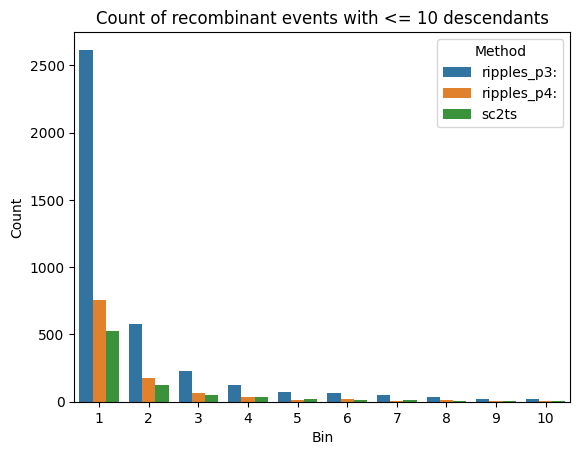

In [18]:
ax = sns.barplot(data=df_lf[df_lf["bins"] < 11], x="Bin", y="Count", hue="Method")
ax.set_title("Count of recombinant events with <= 10 descendants");

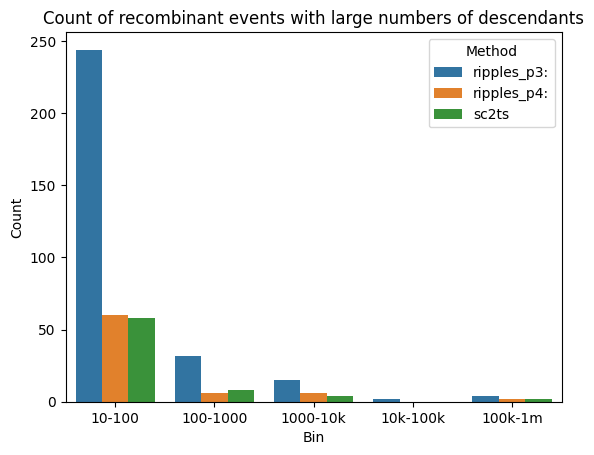

In [19]:
ax = sns.barplot(data=df_lf[df_lf["bins"] >= 11], x="Bin", y="Count", hue="Method");
ax.set_title("Count of recombinant events with large numbers of descendants");

## Singletons

We focus on the singletons as these are unequivocally comparable. Other nodes depend on the inferred topolology. We focus on p=4 as this is comparable with sc2ts.

There are 757 in total, and 705 of these in which sc2ts is also a singleton. Of these, 323 are directly associated with a recombination event, and 254 pass 3SEQ validation, and 228 have all three of the sample and putatative parents as samples. Of these, 216 had at least one parent in which the sampling date was more recent than the child sequence, and on average, the most recent parent comes 63 days after the child. Thus, these trios were not possible for sc2ts, in which enforces strict time ordering on sample dates. 

In [20]:
323 / 757

0.42668428005284015

In [21]:
dfp4_single = dfp4[dfp4["usher_num_descendants"] == 1]
dfp4_single

,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,max_parent_date,min_parent_branch_length,passes_3seq
recombinant,,,,,,,,,,,,,,,,
SRR21610934,SRR21868903,SRR21671375,2022-09-04,2022-09-21,2022-09-06,{'BA.5.2': 1},1360126,1,1189192,6,4,False,1,2022-09-21,-17,True
node_600484,ERR10214302,ERR10003171,2022-12-20,2022-09-08,2022-07-07,{'XBR': 1},1420165,1,1420166,1,0,True,1,2022-09-08,103,False
SRR20186719,SRR20940284,SRR15391719,2021-12-06,2021-12-07,2021-07-21,{'AY.119.2': 1},862839,2,295320,7,5,False,1,2021-12-07,-1,True
ERR6758858,ERR6387616,ERR6440908,2021-09-02,2021-07-22,2021-07-26,{'AY.4': 1},478619,1,478620,1,0,False,1,2021-07-26,38,True
ERR7310305,ERR7284317,ERR6203132,2021-11-02,2021-10-27,2021-06-20,{'AY.4': 1},707305,1,707306,1,0,False,1,2021-10-27,6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR6702609,ERR6634454,ERR6203132,2021-08-23,2021-07-29,2021-06-20,{'AY.4': 1},440103,1,295320,6,0,False,1,2021-07-29,25,True
ERR7395506,ERR6735585,ERR6148731,2021-11-03,2021-09-06,2021-06-21,{'AY.46.5': 1},714838,1,-1,2147483648,5,False,1,2021-09-06,58,True
ERR7307967,ERR7307485,ERR7350337,2021-10-13,2021-10-23,2021-11-02,{'AY.4.2.1': 1},633936,4,633937,1,0,False,1,2021-11-02,-20,True


In [22]:
df = dfp4_single[dfp4_single["sc2ts_num_descendants"] == 1]
df.shape[0]

705

In [23]:
np.sum(df["sc2ts_closest_recombinant_path_len"] == 1)

np.int64(323)

In [24]:
df = df[df["sc2ts_closest_recombinant_path_len"] > 1].copy()

In [25]:
df["passes_3seq"].value_counts()

passes_3seq
True     254
False    128
Name: count, dtype: int64

In [26]:
df = df[df["passes_3seq"]]
df = df.join(df3sp4)
df.shape[0]

254

In [27]:
# Filter out events where child or either parent is not a sample

df = df[~(df["child"].str.contains("node")
          | df["left_parent"].str.contains("node")
          | df["right_parent"].str.contains("node"))]
df.shape[0]

228

In [28]:
df_sample_date = ds.metadata.as_dataframe(["Date_tree"])
# Filter out imprecise dates 
df_sample_date = df_sample_date[df_sample_date["Date_tree"].str.len() == 10]
sample_date = pd.to_datetime(df_sample_date["Date_tree"], format='ISO8601')

In [29]:
df["child_date"] = sample_date[df["child"]]
df["left_parent_date"] = {k: sample_date[row["left_parent"]] for k, row in df.iterrows()} 
df["right_parent_date"] = {k: sample_date[row["right_parent"]] for k, row in df.iterrows()} 
df["min_parent_date"] = {k: min(sample_date[row["right_parent"]], 
                                sample_date[row["left_parent"]]) for k, row in df.iterrows()} 

In [30]:
np.sum((df["child_date"] < df["left_parent_date"]) & (df["child_date"] < df["right_parent_date"]))

np.int64(12)

In [31]:
216 / 228

0.9473684210526315

In [32]:
df = df[df["child_date"] >= df["min_parent_date"]]
df.shape

(216, 36)

<Axes: >

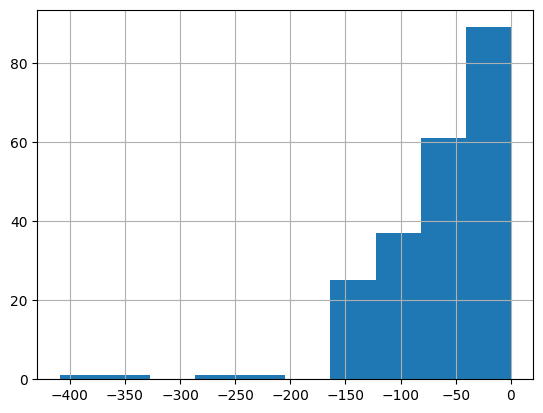

In [33]:
(df["min_parent_date"] - df["child_date"]).dt.days.hist()

In [34]:
(df["min_parent_date"] - df["child_date"]).mean()

Timedelta('-63 days +02:20:00')

## X lineages

In [35]:
dfp3_x = dfp3[dfp3["x_lineage_involved"]].reset_index()
dfp3_x

,recombinant,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,max_parent_date,min_parent_branch_length,in_p4,passes_3seq
0,node_600484,ERR10214302,ERR10003171,2022-12-20,2022-09-08,2022-07-07,{'XBR': 1},1420165,1,1420166,1,0,True,1,2022-09-08,103,True,False
1,node_546458,SRR20664214,node_546449,2023-01-10,2022-07-05,2022-12-20,{'XBB.1.5.7': 1},1427250,1,1396207,9,6,True,1,2022-12-20,21,False,False
2,node_539498,ERR10711783,ERR10839141,2023-01-31,2022-03-14,2023-01-18,{'XBF.2': 2},1432462,2,1420385,2,3,True,2,2023-01-18,13,False,True
3,node_543819,ERR10910984,ERR10003894,2023-02-09,2023-02-06,2022-07-08,{'XBB.1.5': 1},1435037,1,1396207,8,4,True,1,2023-02-06,3,False,False
4,node_600480,ERR10000035,SRR21039681,2022-09-06,2022-07-05,2022-07-25,"{'XBR': 1, 'XBD': 30, 'BA.2.75': 5}",1291791,7182,-1,2147483648,15,True,36,2022-07-25,43,True,False
5,node_545406,ERR10850941,node_545405,2023-02-13,2023-01-12,2023-02-08,{'XBB.1.5.4': 2},1436304,2,1436032,1,0,True,2,2023-02-08,5,True,False
6,node_539409,ERR8035249,ERR10383166,2022-06-30,2022-01-08,2022-10-03,"{'XBF': 124, 'XBB.1.5.67': 25, 'BN.1.2': 97, '...",887654,527719,-1,2147483648,1,True,13803,2022-10-03,-95,False,False
7,node_505768,ERR8761573,ERR7772073,2022-04-20,2022-02-16,2021-12-08,{'XAC': 18},1219046,18,964555,4,5,True,18,2022-02-16,63,True,False
8,node_633544,ERR9399983,ERR8026913,2022-04-01,2022-03-15,2022-01-02,{'XY': 23},1192268,23,1187989,1,0,True,23,2022-03-15,17,False,False
9,node_633571,ERR9099776,ERR10286798,2022-01-19,2022-02-22,2022-09-13,{'XE': 1113},965352,1116,965353,1,2,True,1113,2022-09-13,-237,False,False


In [36]:
dfp3_x[dfp3_x["sc2ts_num_descendants"] != dfp3_x["usher_num_descendants"]]

,recombinant,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,max_parent_date,min_parent_branch_length,in_p4,passes_3seq
4,node_600480,ERR10000035,SRR21039681,2022-09-06,2022-07-05,2022-07-25,"{'XBR': 1, 'XBD': 30, 'BA.2.75': 5}",1291791,7182,-1,2147483648,15,True,36,2022-07-25,43,True,False
6,node_539409,ERR8035249,ERR10383166,2022-06-30,2022-01-08,2022-10-03,"{'XBF': 124, 'XBB.1.5.67': 25, 'BN.1.2': 97, '...",887654,527719,-1,2147483648,1,True,13803,2022-10-03,-95,False,False
9,node_633571,ERR9099776,ERR10286798,2022-01-19,2022-02-22,2022-09-13,{'XE': 1113},965352,1116,965353,1,2,True,1113,2022-09-13,-237,False,False
12,node_539518,ERR10839848,node_600488,2022-06-30,2023-01-23,2022-09-06,"{'BN.1.2': 97, 'CH.1.1': 1484, 'BN.1.7': 94, '...",903506,300569,-1,2147483648,1,True,7147,2023-01-23,-207,True,False
16,node_544473,ERR10706049,ERR10931842,2023-01-27,2022-11-29,2023-01-31,"{'XBB.1.5.25': 12, 'XBB.1.5.78': 1}",1411226,1707,1396207,6,1,True,13,2023-01-31,-4,False,False
19,node_539410,node_539409,node_600480,2022-06-30,2022-06-30,2022-09-06,"{'XBF': 124, 'BN.1.2': 97, 'CH.1.1': 1484, 'BN...",887654,527719,-1,2147483648,1,True,7349,2022-09-06,-68,True,False
22,node_543116,node_543113,ERR10839848,2022-10-12,2022-10-12,2023-01-23,"{'XBB.1.5.67': 25, 'XBB.1.5': 3361, 'XBB': 72,...",1396207,6453,1396207,0,14,True,6452,2023-01-23,-103,False,False
25,node_505720,ERR10039713,ERR5905303,2022-01-18,2022-01-03,2021-04-29,"{'XS': 17, 'BA.1': 1, 'BA.1.1': 1, 'BA.1.15': 1}",220185,1061795,-1,2147483648,1,True,20,2022-01-03,15,False,False
27,node_516786,ERR10001609,ERR9933891,2022-06-09,2022-07-06,2022-07-01,"{'XAJ': 18, 'BA.4': 1}",974731,45209,-1,2147483648,1,True,19,2022-07-06,-27,True,False
32,node_633486,ERR10004182,ERR7969622,2022-01-09,2022-04-19,2021-12-31,"{'XE': 1113, 'XJ': 68, 'BA.2': 82, 'XM': 29, '...",791357,341822,-1,2147483648,2,True,1321,2022-04-19,-100,False,False


In [37]:
dfp3_x["in_p4"].value_counts()

in_p4
False    24
True     15
Name: count, dtype: int64

## Mapping X events to nodes in sc2ts ARG

In [38]:
pango_x_events = pd.read_csv("../data/pango_x_events.csv").set_index("root")
mapping = pango_x_events["root_pango"].to_dict()
import collections
collections.Counter(mapping.values()).most_common(5)


[('XM', 4), ('XAC', 4), ('XAD', 2), ('XA', 1), ('XJ', 1)]

The mapping is messy here because of 3 X lineages which we need to disambiguate. There's only two XAD samples which are both under Xx. They don't show up in the RIPPLES results, so let's not worry about them


### XAC
XAC is really one event, it's just because of mislabelling in by Pangolin. The MRCA of the XACs really is the same node in both

In [39]:
ts = tszip.load("../data/sc2ts_viridian_v1.2.trees.tsz")
dfn = sc2ts.node_data(ts, inheritance_stats=False)
df_sample = dfn[dfn["is_sample"]]

In [40]:
df_xac = df_sample[df_sample["pango"] == "XAC"]
xac_mrca = ts.first().mrca(*df_xac["node_id"].values)
xac_mrca

1219046

In [41]:
dfp4[dfp4["pango_counts"] == {'XAC': 18}]

,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,sc2ts_closest_recombinant_path_len,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,max_parent_date,min_parent_branch_length,passes_3seq
recombinant,,,,,,,,,,,,,,,,


In [42]:
{k: v for k, v in mapping.items() if v == "XAC"}

{1223586: 'XAC', 2744536: 'XAC', 1214068: 'XAC', 1235679: 'XAC'}

In [43]:
mapping = {k: v for k, v in mapping.items() if v != "XAC"}
mapping[xac_mrca] = "XAC"

### XM

XM is messy because we have 4 different events in the ARG. We call the major one XM, and then the minor ones XM1, 2, arbitrarily.

In [44]:
pango_x_events[pango_x_events["pango"] == "XM"]

,root_pango,root_mutations,root_type,pango_samples,non_pango_samples,closest_recombinant,closest_recombinant_path_len,closest_recombinant_time,closest_recombinant_descendants,pango
root,,,,,,,,,,
938900,XM,2,R,1,{},938900,0.0,0.0,{'XM': 1},XM
1003220,XM,0,R,26,"{'BA.2': 16, 'XAL': 3}",1003220,0.0,0.0,"{'XM': 26, 'BA.2': 16, 'XAL': 3}",XM
1158127,XM,1,R,1,{},1158127,0.0,0.0,{'XM': 1},XM
1158182,XM,6,R,1,{},1158182,0.0,0.0,{'XM': 1},XM


## XBM

XBM is a type II event, with the recomb slightly ancestral to the clade 


In [45]:
mapping = {k: v for k, v in mapping.items() if v != "XBM"}
node = pango_x_events[pango_x_events["root_pango"] == "XBM"]["closest_recombinant"].values[0]
mapping[int(node)] = "XBM"

In [46]:
j = 1
for root, row in pango_x_events[pango_x_events["pango"] == "XM"].iterrows():
    if row["pango_samples"] == 1:
        mapping[root] = f"XM{j}"
        j += 1


In [47]:
collections.Counter(mapping.values()).most_common(5)

[('XAD', 2), ('XA', 1), ('XJ', 1), ('XB', 1), ('XAP', 1)]

In [48]:
# Remove the novel XBB.1 also
mapping = {k: v for k, v in mapping.items() if v not in ["XAD", "XBB.1"]}

In [49]:
node = pango_x_events[pango_x_events["root_pango"] == "XH"]["closest_recombinant"].values[0]
mapping[int(node)] = "XE/XH"

node = pango_x_events[pango_x_events["root_pango"] == "XZ"]["closest_recombinant"].values[0]
mapping[int(node)] = "Xx"



In [50]:
mapping

{122444: 'XA',
 966904: 'XJ',
 223239: 'XB',
 1216836: 'XAP',
 1301399: 'XAN',
 1187989: 'XY',
 1420385: 'XBF',
 1148222: 'XR',
 1058654: 'XQ',
 1163537: 'XZ',
 1243765: 'XU',
 1240312: 'XAM',
 1183815: 'XAA',
 1363926: 'XBE',
 1098084: 'XH',
 1420166: 'XBR',
 1000242: 'XS',
 1159411: 'XW',
 1264107: 'XAL',
 1061700: 'XN',
 414488: 'XC',
 1248341: 'XAG',
 1276376: 'XAJ',
 938900: 'XM1',
 1003220: 'XM',
 1158127: 'XM2',
 1158182: 'XM3',
 1425824: 'XBK',
 1118099: 'XAE',
 1396207: 'XBB',
 946761: 'XF',
 1231548: 'XAU',
 1092789: 'XP',
 1422955: 'XBQ',
 1285706: 'XAZ',
 1265115: 'XAS',
 1291970: 'XBG',
 1269391: 'XAV',
 1083412: 'XG',
 1034619: 'XL',
 1314603: 'XAF',
 1379419: 'XBH',
 965352: 'XE',
 1378208: 'XBD',
 1219046: 'XAC',
 1348822: 'XBM',
 965353: 'XE/XH',
 964555: 'Xx'}

In [51]:
assert len(set(mapping.values())) == len(mapping)
df_sc2ts["event_label"] = {k: mapping.get(k, "novel") for k in df_sc2ts.index}
df_sc2ts_x_events = df_sc2ts[df_sc2ts["event_label"] != "novel"]
df_sc2ts_x_events

,sample_id,num_descendant_samples,num_samples,distinct_sample_pango,interval_left,interval_right,num_mutations,Viridian_amplicon_scheme,Artic_primer_version,date_added,...,parent_pangonet_distance,net_min_supporting_loci_lft,net_min_supporting_loci_rgt,net_min_supporting_loci_lft_rgt_ge_4,k1000_muts,event_label,ripples_p4,ripples_p3,is_ripples_p4_recombinant,is_ripples_p3_recombinant
recombinant,,,,,,,,,,,,,,,,,,,,,
1159411,ERR9444530,32,1,1,2833,4321,1,COVID-ARTIC-V4.1,4.1alt,2022-03-20,...,4,5,48,True,5,XW,False,True,False,True
1058654,ERR8691075,154,1,1,4322,5386,0,COVID-ARTIC-V4.1,4.1alt,2022-02-12,...,5,8,43,True,7,XQ,False,False,False,False
946761,ERR8076129,16,1,1,5387,6402,1,COVID-ARTIC-V4.1,4.1alt,2022-01-13,...,6,6,74,True,6,XF,False,False,False,False
1083412,ERR9089519,3,1,1,5925,6513,3,COVID-ARTIC-V4.1,4.1alt,2022-02-19,...,3,9,38,True,7,XG,False,False,False,False
1034619,ERR8627711,64,3,1,5925,8393,1,COVID-ARTIC-V4.1,4.1alt,2022-02-06,...,5,10,40,True,9,XL,False,True,False,True
1420385,ERR10708634,185,11,3,5184,9866,4,COVID-ARTIC-V4.1,4.1alt,2022-12-20,...,10,8,29,True,9,XBF,False,False,False,False
1000242,SRR19817338,17,1,1,9054,10449,2,COVID-AMPLISEQ-V1,.,2022-01-28,...,7,16,76,True,13,XS,True,True,True,True
965353,ERR8153803,1156,1,1,10448,11283,1,COVID-ARTIC-V4.1,4.1alt,2022-01-19,...,4,15,33,True,7,XE/XH,False,False,False,False
1187989,SRR20520593,23,1,1,11538,12880,3,COVID-ARTIC-V4.1,.,2022-04-01,...,3,22,31,True,8,XY,False,True,False,True


## Matching up events between sc2ts and Usher+ripples

In [52]:
def label_events(df):
    event_label = {}
    sc2ts_event_label = {}
    for key, row in df.iterrows():
        d = row["pango_counts"]
        event_label[key] = "messy"
        if len(d) == 1:
            event_label[key] = list(d.keys())[0]
        sc2ts_event_label[key] = mapping.get(row["sc2ts_closest_recombinant"], "NA")
        if "XB" in d:
            sc2ts_event_label[key] = "XB"
    df["event_label"] = event_label
    df["sc2ts_event_label"] = sc2ts_event_label
    return df
            


dfp3_x = label_events(dfp3_x).copy()

In [53]:
# Manually correct the recombinant path lens for a few 
events = ["XBR", "XM3", "XY", "XW"]

dfp3_x.loc[dfp3_x["sc2ts_event_label"].isin(events), "sc2ts_closest_recombinant_path_len"] = 0

In [54]:
sc2ts_event_type = {}
for k, row in dfp3_x.iterrows():
    path_len = row["sc2ts_closest_recombinant_path_len"]
    if path_len == 0:
        e = "I"
    elif path_len < 10**6:
        e = "II"
    else:
        e = "NA"
    if "XB" in row["pango_counts"]:
        e = "IV"
    sc2ts_event_type[k] = e


dfp3_x["sc2ts_event_type"] = sc2ts_event_type

In [55]:
t = dfp3_x.sort_values(["sc2ts_event_type", "usher_num_descendants"])
t["clade_diff"] = t["sc2ts_num_descendants"] - t["usher_num_descendants"] 

t = t[["sc2ts_event_label", "in_p4", "usher_num_descendants", "sc2ts_event_type", "clade_diff", "pango_counts"]]
t

,sc2ts_event_label,in_p4,usher_num_descendants,sc2ts_event_type,clade_diff,pango_counts
37,XM3,True,1,I,0,{'XM': 1}
11,XC,True,5,I,0,{'XC': 5}
34,XS,True,17,I,0,{'XS': 17}
8,XY,False,23,I,0,{'XY': 23}
20,XW,False,32,I,0,{'XW': 32}
18,XA,True,39,I,0,{'XA': 39}
13,XL,False,64,I,0,{'XL': 64}
15,XQ,False,1,II,0,{'XAM': 1}
14,XM,True,8,II,0,"{'XM': 4, 'BA.2': 4}"
30,Xx,False,9,II,0,{'XAE': 9}


In [56]:
col_name_map = {
    "sc2ts_event_label": "pango",
    "in_p4": "in p4",
    "usher_num_descendants": "UShER desc", 
    "sc2ts_event_type": "sc2ts class",
    "clade_diff": "clade diff",
    "pango_counts": "descendants",
  
    #"closest_recombinant_descendants": "by pango",
}
s = t[list(col_name_map.keys())].to_latex(
        escape=False, index=False, header=list(col_name_map.values()),
        float_format="%.0f")
s = s.replace("'", "").replace(": ", ":") 

print(s)

\begin{tabular}{lrrlrl}
\toprule
pango & in p4 & UShER desc & sc2ts class & clade diff & descendants \\
\midrule
XM3 & True & 1 & I & 0 & {XM:1} \\
XC & True & 5 & I & 0 & {XC:5} \\
XS & True & 17 & I & 0 & {XS:17} \\
XY & False & 23 & I & 0 & {XY:23} \\
XW & False & 32 & I & 0 & {XW:32} \\
XA & True & 39 & I & 0 & {XA:39} \\
XL & False & 64 & I & 0 & {XL:64} \\
XQ & False & 1 & II & 0 & {XAM:1} \\
XM & True & 8 & II & 0 & {XM:4, BA.2:4} \\
Xx & False & 9 & II & 0 & {XAE:9} \\
Xx & True & 18 & II & 0 & {XAC:18} \\
XQ & False & 21 & II & 0 & {XAM:21} \\
XE/XH & False & 1113 & II & 3 & {XE:1113} \\
XB & True & 1 & IV & 0 & {XBR:1} \\
XB & False & 1 & IV & 0 & {XBB.1.5.7:1} \\
XB & False & 1 & IV & 0 & {XBB.1.5:1} \\
XB & False & 1 & IV & 0 & {XBB.1.5:1} \\
XB & False & 1 & IV & 0 & {XBB.1.5.4:1} \\
XB & False & 1 & IV & 0 & {XBB.1.5:1} \\
XB & False & 1 & IV & 0 & {XBB.1.5:1} \\
XB & False & 1 & IV & 0 & {XBB.2.6:1} \\
XB & False & 1 & IV & 0 & {XBB.1.5:1} \\
XB & False & 2 & IV & 0 & {X

In [57]:
dfp3_x[dfp3_x.event_label != "messy"]

,recombinant,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,...,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,max_parent_date,min_parent_branch_length,in_p4,passes_3seq,event_label,sc2ts_event_label,sc2ts_event_type


In [58]:
dfp3_x[dfp3_x.event_label == "messy"]

,recombinant,parent1,parent2,recombinant_date,parent1_date,parent2_date,pango_counts,sc2ts_mrca,sc2ts_num_descendants,sc2ts_closest_recombinant,...,sc2ts_num_mutations,x_lineage_involved,usher_num_descendants,max_parent_date,min_parent_branch_length,in_p4,passes_3seq,event_label,sc2ts_event_label,sc2ts_event_type
0,node_600484,ERR10214302,ERR10003171,2022-12-20,2022-09-08,2022-07-07,{'XBR': 1},1420165,1,1420166,...,0,True,1,2022-09-08,103,True,False,messy,XB,IV
1,node_546458,SRR20664214,node_546449,2023-01-10,2022-07-05,2022-12-20,{'XBB.1.5.7': 1},1427250,1,1396207,...,6,True,1,2022-12-20,21,False,False,messy,XB,IV
2,node_539498,ERR10711783,ERR10839141,2023-01-31,2022-03-14,2023-01-18,{'XBF.2': 2},1432462,2,1420385,...,3,True,2,2023-01-18,13,False,True,messy,XB,IV
3,node_543819,ERR10910984,ERR10003894,2023-02-09,2023-02-06,2022-07-08,{'XBB.1.5': 1},1435037,1,1396207,...,4,True,1,2023-02-06,3,False,False,messy,XB,IV
4,node_600480,ERR10000035,SRR21039681,2022-09-06,2022-07-05,2022-07-25,"{'XBR': 1, 'XBD': 30, 'BA.2.75': 5}",1291791,7182,-1,...,15,True,36,2022-07-25,43,True,False,messy,XB,IV
5,node_545406,ERR10850941,node_545405,2023-02-13,2023-01-12,2023-02-08,{'XBB.1.5.4': 2},1436304,2,1436032,...,0,True,2,2023-02-08,5,True,False,messy,XB,IV
6,node_539409,ERR8035249,ERR10383166,2022-06-30,2022-01-08,2022-10-03,"{'XBF': 124, 'XBB.1.5.67': 25, 'BN.1.2': 97, '...",887654,527719,-1,...,1,True,13803,2022-10-03,-95,False,False,messy,XB,IV
7,node_505768,ERR8761573,ERR7772073,2022-04-20,2022-02-16,2021-12-08,{'XAC': 18},1219046,18,964555,...,5,True,18,2022-02-16,63,True,False,messy,Xx,II
8,node_633544,ERR9399983,ERR8026913,2022-04-01,2022-03-15,2022-01-02,{'XY': 23},1192268,23,1187989,...,0,True,23,2022-03-15,17,False,False,messy,XY,I
9,node_633571,ERR9099776,ERR10286798,2022-01-19,2022-02-22,2022-09-13,{'XE': 1113},965352,1116,965353,...,2,True,1113,2022-09-13,-237,False,False,messy,XE/XH,II


In [59]:
dfp3_x[dfp3_x.event_label != "messy"].join(df_sc2ts, on="sc2ts_closest_recombinant", rsuffix="_sc2ts")[["event_label", "event_label_sc2ts"]]

,event_label,event_label_sc2ts


In [60]:
cols = ["event_label", "event_label_sc2ts", "usher_num_descendants", "sc2ts_num_descendants"]
t = dfp3_x[dfp3_x.event_label != "messy"].join(df_sc2ts, on="sc2ts_closest_recombinant", rsuffix="_sc2ts")
tmp = t[t["in_p4"]][cols]
print(tmp.to_latex(index=False))

\begin{tabular}{llrr}
\toprule
event_label & event_label_sc2ts & usher_num_descendants & sc2ts_num_descendants \\
\midrule
\bottomrule
\end{tabular}



In [61]:
tmp = t[~t["in_p4"]][cols]
print(tmp.to_latex(index=False))

\begin{tabular}{llrr}
\toprule
event_label & event_label_sc2ts & usher_num_descendants & sc2ts_num_descendants \\
\midrule
\bottomrule
\end{tabular}



# Singletons



In [62]:
df_sc2ts_single = df_sc2ts[df_sc2ts["num_descendant_samples"] == 1]
df_sc2ts_single.shape

(525, 52)

In [63]:
dfp3_single = dfp3[dfp3["usher_num_descendants"] == 1]
dfp3_single.shape

(2616, 17)

In [64]:
dfp3_single.in_p4.value_counts()

in_p4
False    1862
True      754
Name: count, dtype: int64

In [65]:
df_join = dfp3_single.join(df_sc2ts_single, "sc2ts_closest_recombinant")
df_join = df_join[df_join["sc2ts_closest_recombinant_path_len"] == 1]
df_join

ValueError: columns overlap but no suffix specified: Index(['recombinant_date'], dtype='object')

In [ ]:
df_join.in_p4.value_counts()

In [ ]:
total_sc2ts = df_sc2ts_single.shape[0]
total_p3 = dfp3_single.shape[0]
total_p4 = np.sum(dfp3_single["in_p4"])
inter_p3 = df_join.shape[0]
inter_p4 = np.sum(df_join["in_p4"])

print("Singletons")
print("Total sc2ts =", total_sc2ts)
print("Total RIPPLES p3 =", total_p3)
print("Intersection  p3 = ", inter_p3)
print("Total RIPPLES p4 =", total_p4)
print("Intersection  p4 = ", inter_p4)

In [ ]:
# accept as their only required argument a 3-element tuple (Ab, aB, AB)
matplotlib_venn.venn2([total_p4 - inter_p4, total_sc2ts - inter_p4, inter_p4], [f"RIPPLES p4", "sc2ts"]);

In [ ]:
matplotlib_venn.venn2([total_p3 - inter_p3, total_sc2ts - inter_p3,  inter_p3], [f"RIPPLES p4", "sc2ts"]);




### Overall

In [ ]:
def get_sc2ts_recombinants(df, clade_agreement_threshold=1, closeness=1):
    diffs = df["sc2ts_num_descendants"] - df["usher_num_descendants"]
    clade_agreement = diffs <= clade_agreement_threshold
    print(f"Clade agreement = {clade_agreement.sum()} {clade_agreement.sum() / df.shape[0]:.1%}")
    df = df[clade_agreement]
    close_to_recombinant = df["sc2ts_closest_recombinant_path_len"] <= closeness
    not_recombinant = df["sc2ts_closest_recombinant"] == -1
    print(f"Non recombinant = {not_recombinant.sum() / df.shape[0]:.1%}")
    print(f"Close to recombinant = {close_to_recombinant.sum() / df.shape[0]:.1%}")
    df = df[close_to_recombinant]
    print("Passing filter = ", df.shape[0])
    #print(df["sc2ts_closest_recombinant"].value_counts())
    sc2ts_recombs = df["sc2ts_closest_recombinant"].unique()
    return sc2ts_recombs
    
def draw_venn(df, label, sc2ts_recombs, ax=None):
    total_ripples = df.shape[0]
    total_sc2ts = 855
    shared = sc2ts_recombs.shape[0]
    print("Total ripples =", total_ripples)
    print("Total sc2ts = ", total_sc2ts)
    # Note: it would be nice to fix the size of the sc2ts circle here an let the 
    # ripples one get bigger, but it's not obvious how to do it.
    layout_algorithm = matplotlib_venn.layout.venn2.DefaultLayoutAlgorithm()
    matplotlib_venn.venn2(
        [total_ripples - shared, total_sc2ts - shared, shared], 
        [f"RIPPLES {label} ({total_ripples})", f"sc2ts ({total_sc2ts})"], 
        layout_algorithm=layout_algorithm, ax=ax);

sc2ts_recombs_p3 = get_sc2ts_recombinants(dfp3, clade_agreement_threshold=1, closeness=1)
draw_venn(dfp3, "p3", sc2ts_recombs_p3)
plt.savefig("../figures/ripples_p3_sc2ts_events.pdf")

In [ ]:
sc2ts_recombs_p4 = get_sc2ts_recombinants(dfp4) #dfp3[dfp3["in_p4"]])
draw_venn(dfp4, "p4", sc2ts_recombs_p4)
plt.savefig("../figures/ripples_p4_sc2ts_events.pdf")

### Intersection analysis for paper

This is the analysis I used for the paper.

In [ ]:
468 / 1174

In [ ]:
468 / 855

In [ ]:
595/855

In [ ]:
p4recombinants = get_sc2ts_recombinants(dfp4)

In [ ]:
dfp4_not_sc2ts = dfp4[~dfp4.sc2ts_closest_recombinant.isin(p4recombinants)]
dfp4_not_sc2ts

In [ ]:
np.sum(dfp4_not_sc2ts["min_parent_branch_length"] <= 0)

In [ ]:
dfp4_not_sc2ts_not_tt = dfp4_not_sc2ts[dfp4_not_sc2ts["min_parent_branch_length"] > 0]
stragglers = dfp4_not_sc2ts_not_tt[
    ((dfp4_not_sc2ts_not_tt["sc2ts_num_descendants"] - dfp4_not_sc2ts_not_tt["usher_num_descendants"]).abs() < 2) &
    (dfp4_not_sc2ts_not_tt["sc2ts_num_mutations"] > 4)]
stragglers

In [ ]:
remap_sites = pd.read_csv("../arg_postprocessing/sc2ts_v1_2023-02-21_pr_pp_sites_to_remap.csv")
remap_sites

In [ ]:
df_mutation = sc2ts.mutation_data(ts)

In [ ]:
straggler_mutations = df_mutation[df_mutation["node"].isin(stragglers["sc2ts_mrca"])]
straggler_mutations

In [ ]:
np.sum(straggler_mutations["position"].isin(remap_sites["position"]))

## Add Ripples p3/p4 classification to sc2ts dataframe

In [ ]:
df_sc2ts["is_ripples_p4_recombinant"] = {k: k in sc2ts_recombs_p4 for k in df_sc2ts.index}
df_sc2ts["is_ripples_p3_recombinant"] = {k: k in sc2ts_recombs_p3 for k in df_sc2ts.index}
df_sc2ts

In [ ]:
# TODO add this to the data frame automatically.

In [ ]:
df_sc2ts.reset_index().to_csv("../data/recombinants.csv", index=False)

In [ ]:
dfp4

In [ ]:
dfp4_close2

In [ ]:
(dfp4["min_parent_branch_length"] <= 0).value_counts()

In [ ]:
df_ttp = dfp4[dfp4["min_parent_branch_length"] < 0]
df_ttp

In [ ]:
np.sum(df_ttp["sc2ts_closest_recombinant_path_len"] <= 2)

In [ ]:
pass3s = dfp4[dfp4["passes_3seq"]]
pass3s

In [ ]:
(pass3s["sc2ts_closest_recombinant_path_len"] < 3).value_counts()

In [ ]:
fail3s = dfp4[~dfp4["passes_3seq"]]
fail3s

In [ ]:
(fail3s["sc2ts_closest_recombinant_path_len"] < 3).value_counts()

In [ ]:
sc2ts_close = dfp4[dfp4["sc2ts_closest_recombinant_path_len"] < 3]
sc2ts_close

In [ ]:
sc2ts_close["passes_3seq"].value_counts()

In [ ]:
not_sc2ts_close = dfp4[dfp4["sc2ts_closest_recombinant_path_len"] >= 3]
not_sc2ts_close

In [ ]:
not_sc2ts_close["passes_3seq"].value_counts()

In [ ]:
not_sc2ts_close["min_parent_branch_length"].hist()

In [ ]:
not_sc2ts_close[not_sc2ts_close["passes_3seq"]]["min_parent_branch_length"].hist()

In [ ]:
sc2ts_should_find = not_sc2ts_close[not_sc2ts_close["passes_3seq"] & (not_sc2ts_close["min_parent_branch_length"] >0)
    & (not_sc2ts_close["sc2ts_num_mutations"] > 4)]
sc2ts_should_find

In [ ]:
ts = tszip.load("../data/sc2ts_viridian_v1.2.trees.tsz")
df_node = sc2ts.node_data(ts)

In [ ]:
df_sample = df_node[df_node.is_sample].set_index("sample_id")

In [ ]:
df_sample.loc[["SRR21173296", "SRR16900296", "ERR6634797"]]


In [ ]:
tss = ts.simplify([685800, 656285, 449467])
tss.draw_svg(size=[800, 800])

In [ ]:
np.sum(tss.mutations_node == 3)

In [ ]:
tss.tables.mutations[tss.mutations_node == 0]

In [ ]:
tss.tables.mutations[tss.mutations_node == 1]

In [ ]:
tss.tables.mutations[tss.mutations_node == 2]

In [ ]:
ts.sites_position[range(39, 47)]

In [ ]:
tss.sites_position[tss.mutations_site[tss.mutations_node == 0]]

In [ ]:
recombinant_samples = [s for s in sc2ts_should_find.index if "node" not in s]
df_missing_recombinants = df_sample.loc[recombinant_samples]
df_missing_recombinants.shape

In [ ]:

df_mutation = sc2ts.mutation_data(ts)
df_mutation

In [ ]:
missing_recomb_mutations = df_mutation[df_mutation.node.isin(df_missing_recombinants.node_id)]
missing_recomb_mutations

In [ ]:
missing_recomb_mutations["position"].value_counts()

In [ ]:
remap_sites = pd.read_csv("../arg_postprocessing/sc2ts_v1_2023-02-21_pr_pp_sites_to_remap.csv")
remap_sites

In [ ]:
np.sum(missing_recomb_mutations["position"].isin(remap_sites["position"]))